In [1]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools
from scipy import interpolate
 
import csv

In [2]:
# VARIABLES

#path_raw = 'H:/MSci Project/sand_outside' #path containing all raw spectra RACHEL
path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/Emissivity_data' #path containing all raw spectra

In [3]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance

In [4]:
h = 6.626e-34
c = 3.0e+8
k = 1.381e-23

planck_a = 2*h*(c**2)
planck_e = h*c/k

print(planck_a)
print(planck_e)

1.19268e-16
0.014393917451122376


In [ ]:
# choose files that are taken around one of Laura's transmissions

transmission_indeces = []
hbb_indeces = []
cbb_indeces = []
sky_indeces = []
water_indeces = []

In [5]:
downwelling_file = read_file(path_raw, 'downwelling.csv', separator='\t', rowstoskip=None, head=None)
upwelling_file = read_file(path_raw, 'upwelling.csv', separator='\t', rowstoskip=None, head=None)
down = downwelling_file[1]
down_wn = downwelling_file[0]
up = upwelling_file[1]
trans_file = np.loadtxt(path_raw + '/2239_2799.txt')

tau_wn= []
taus_rtm = []
for i in np.arange(trans_file.shape[0]):
    tau_wn.append(trans_file[i][0])
    taus_rtm.append(trans_file[i][1])

f_trans = interpolate.interp1d(tau_wn, taus_rtm)

taus = []
wns=[]
downs = []
ups = []

for i in range(len(down_wn)):
    if f_trans(down_wn[i]) >0.95:
        taus.append(f_trans(down_wn[i]))
        wns.append(down_wn[i])
        downs.append(down[i])
        ups.append(up[i])

In [6]:
def plot_planck(t, wns):
    radiances = []
    for w in wns:
        radiances.append(planck(w, t+273.15))
    return radiances

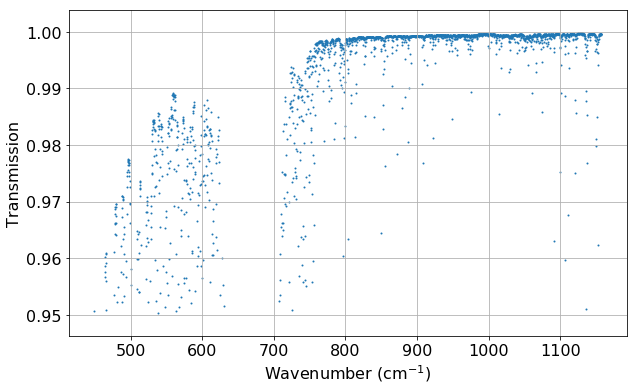

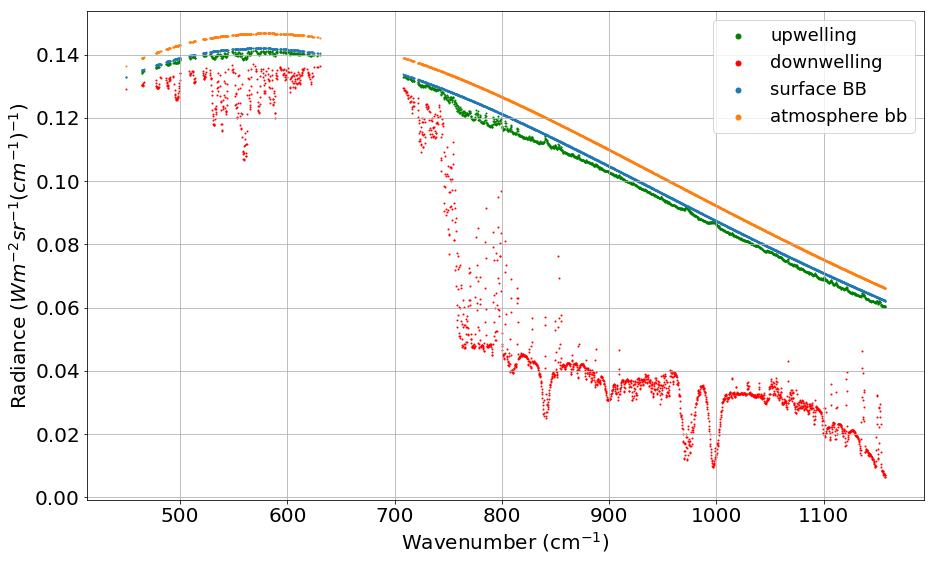

In [7]:
fig = plt.figure(figsize=(10,6), facecolor='white')
plt.scatter(wns, taus, s=1)
plt.tick_params(labelsize=16)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=16)
plt.ylabel('Transmission', fontsize=16)
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9), facecolor='white')
plt.scatter(wns, ups, s=1, c='green')
plt.scatter(wns, downs, s=1, c='r')
BBatm = plot_planck(22.4, wns)
BBsurf = plot_planck(19.2, wns)
plt.scatter(wns, BBsurf, s=1)
plt.scatter(wns, BBatm, s=1)
plt.tick_params(labelsize=20)
plt.grid()
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Radiance ($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)', fontsize=20)
legend = plt.legend(['upwelling', 'downwelling', 'surface BB', 'atmosphere bb'], fontsize=18, frameon=True, markerscale=5)
plt.show()

In [8]:
N1 = np.array(ups)
N2 = np.array([t**2*d for t, d in zip(taus, downs)])
N3 = np.array([(1-t**2)*b for t, b in zip(taus, BBatm)])

N = N1-N2-N3

D1 = np.array([t*b for t, b in zip(taus, BBsurf)])
D2 = np.array([t**2*d for t, d in zip(taus, downs)])
D3 = np.array([t*(1-t)*b for t, b in zip(taus, BBatm)])

D = D1-D2-D3

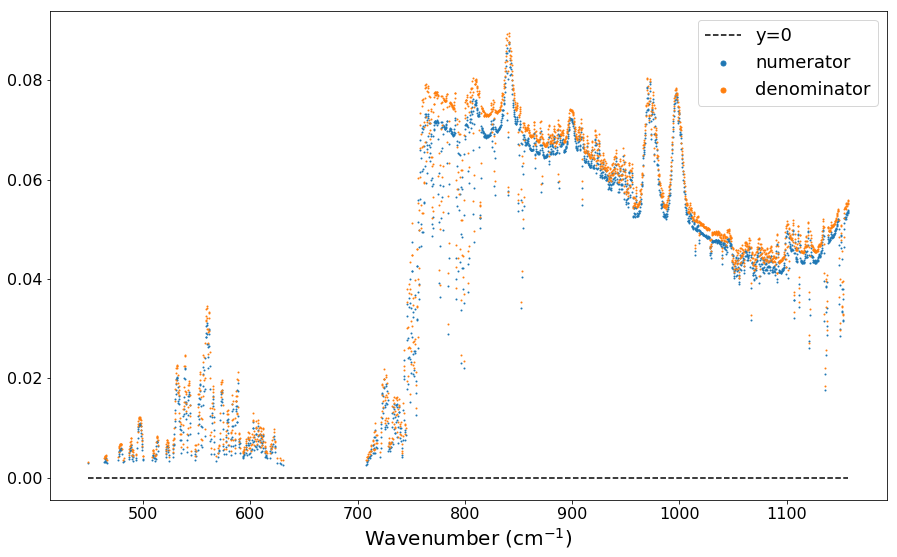

In [9]:
fig = plt.figure(figsize=(15,9), facecolor='white')
plt.plot([min(wns), max(wns)], [0,0], 'k--')
plt.scatter(wns, N, s=1)
plt.scatter(wns, D, s=1)
plt.tick_params(labelsize=16)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
legend = plt.legend(['y=0', 'numerator', 'denominator'], fontsize=18, frameon=True, markerscale=5)
plt.show()

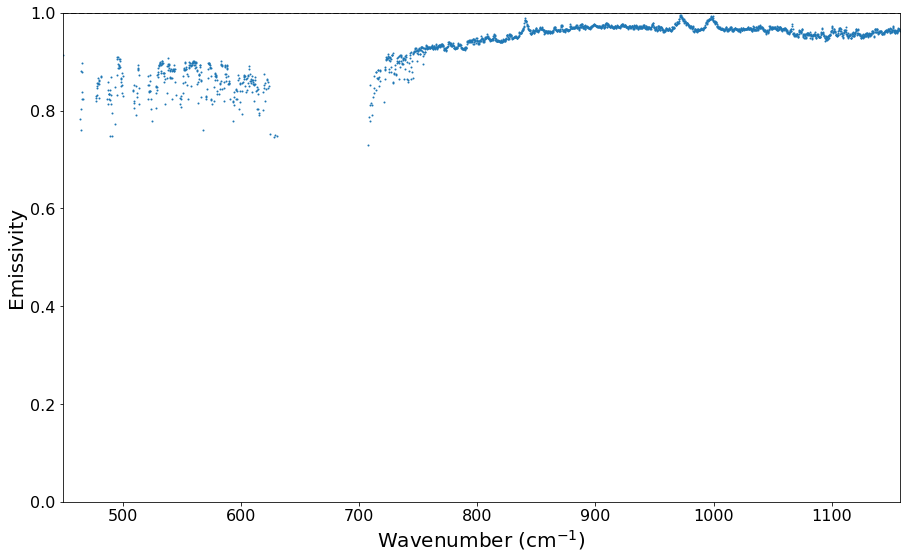

In [20]:
fig = plt.figure(figsize=(15,9), facecolor='white')
plt.scatter(wns, N/D, s=1)
plt.ylim([0,1])
plt.xlim([min(wns), max(wns)])
plt.plot([min(wns), max(wns)], [1,1], 'k--')
plt.tick_params(labelsize=16)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.show()

In [11]:
print(D1)

[ 0.12636882  0.12923304  0.1295206  ...,  0.06220423  0.06216254
  0.06213145]


In [12]:
print(D2)

[ 0.11674924  0.11949344  0.11974021 ...,  0.00689986  0.00626745
  0.00635551]


In [13]:
print(D3)

[  6.40887629e-03   5.73992469e-03   5.49956339e-03 ...,   2.16805844e-05
   2.85586548e-05   2.41860844e-05]


In [14]:
print(N3)

[  1.31505798e-02   1.17390549e-02   1.12360764e-02 ...,   4.33682742e-05
   5.71296477e-05   4.83810216e-05]


In [15]:
print(D)

[ 0.0032107   0.00399968  0.00428082 ...,  0.05528269  0.05586652
  0.05575175]


In [16]:
print(len(wns))

2169


TODO

#Corrrect emissivity equation

do with sand

see how stable emissivity is over time

if time, look at BB emissivity paper and incorporate that in our model. Take red line in figures 5,6 or interpolate between two 

see whether it has a big effect on emissivity - should see a jump around 1000 wavenums

uncertainyt in atm temp - what does it do to emissivity
uncertainty in transmittance - what does it do


Maybe plot our emissivities on top of Newman values. Maybe with uncertainties we are in the range
In the FIR look at FIR for sea water (maybe in supplementary materials). Emissivities went much lower? Difference is wiht salinity
Newman in FIR has not much effect of salinity 

Report: characterise instrument, e values and error analysis, comparison to previous papers

For errors:
     in the code estimate uncertainty in surface temperature, and put it in code keeping everything else constant - see effects of varyinf surf temp and same for all other components in the formula.